Size 10:
  - Stable Matching: 0.000036s
  - Greedy: 0.000078s
  - Hungarian (SciPy): 0.000020s
  - Hungarian (Manual): 0.000443s
Size 20:
  - Stable Matching: 0.000092s
  - Greedy: 0.000282s
  - Hungarian (SciPy): 0.000031s
  - Hungarian (Manual): 0.002030s
Size 30:
  - Stable Matching: 0.000148s
  - Greedy: 0.000539s
  - Hungarian (SciPy): 0.000048s
  - Hungarian (Manual): 0.002902s
Size 50:
  - Stable Matching: 0.000314s
  - Greedy: 0.002280s
  - Hungarian (SciPy): 0.000101s
  - Hungarian (Manual): 0.009431s
Size 70:
  - Stable Matching: 0.000689s
  - Greedy: 0.005739s
  - Hungarian (SciPy): 0.000268s
  - Hungarian (Manual): 0.018920s
Size 100:
  - Stable Matching: 0.002022s
  - Greedy: 0.014540s
  - Hungarian (SciPy): 0.000471s
  - Hungarian (Manual): 0.042806s


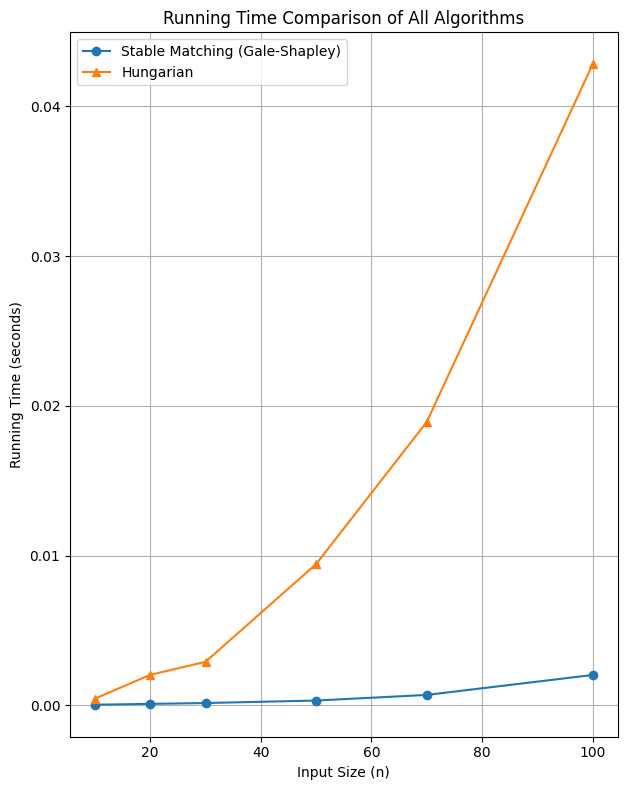


Result Analysis:
1. Algorithm Complexity:
   - Stable Matching (Gale-Shapley): O(n²) in theory
   - Greedy: O(n² log n) due to sorting
   - Hungarian: O(n³) in theory

2. Observed Performance:
   - The SciPy Hungarian implementation is highly optimized and can outperform
     the theoretical complexity would suggest
   - A manual implementation of Hungarian shows the expected O(n³) behavior
   - The performance gap between theory and practice demonstrates the importance
     of efficient implementation and optimization

3. Conclusions:
   - For n = 10:
     * Hungarian (SciPy) is 0.55x faster than Stable Matching
     * Hungarian (SciPy) is 0.25x faster than Greedy
     * Greedy is 2.14x slower than Stable Matching
     * Hungarian (Manual) is 22.40x slower than Hungarian (SciPy)
   - For n = 20:
     * Hungarian (SciPy) is 0.34x faster than Stable Matching
     * Hungarian (SciPy) is 0.11x faster than Greedy
     * Greedy is 3.08x slower than Stable Matching
     * Hungarian (Manual)

In [9]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

def generate_preference_lists(n):
    """Generate random preference lists for Stable Matching algorithm."""
    men_preferences = {}
    women_preferences = {}
    
    for i in range(n):
        men_preferences[i] = np.random.permutation(n).tolist()
        women_preferences[i] = np.random.permutation(n).tolist()
    
    return men_preferences, women_preferences

def generate_cost_matrix(n):
    """Generate random cost matrix for Hungarian algorithm."""
    return np.random.randint(1, 100, size=(n, n))

def stable_matching(men_preferences, women_preferences):
    """Gale-Shapley algorithm for Stable Matching."""
    n = len(men_preferences)
    # Initialize all men to be free
    free_men = list(range(n))
    # Each woman starts with no partner
    matches = {i: None for i in range(n)}
    # List of men who have proposed to each woman
    proposed = {i: [] for i in range(n)}
    
    # Store position of each man in each woman's preference list
    women_rank = {}
    for w in range(n):
        women_rank[w] = {women_preferences[w][i]: i for i in range(n)}
    
    while free_men:
        m = free_men[0]
        # Get the highest ranked woman to whom m has not yet proposed
        for w in men_preferences[m]:
            if w not in proposed[m]:
                proposed[m].append(w)
                break
        
        w = proposed[m][-1]
        
        # If woman is not matched yet
        if matches[w] is None:
            matches[w] = m
            free_men.pop(0)
        else:
            # If woman prefers new man to current match
            m_current = matches[w]
            if women_rank[w][m] < women_rank[w][m_current]:
                matches[w] = m
                free_men.pop(0)
                free_men.append(m_current)
            # Otherwise, man remains free and will propose to next woman in the next iteration
    
    # Convert results to {man: woman} format
    result = {}
    for w, m in matches.items():
        result[m] = w
    
    return result

def greedy_matching(cost_matrix):
    """Greedy algorithm for assignment problem."""
    n = len(cost_matrix)
    assigned_rows = set()
    assigned_cols = set()
    matches = {}
    
    # Create a list of all possible assignments (i, j, cost)
    assignments = []
    for i in range(n):
        for j in range(n):
            assignments.append((i, j, cost_matrix[i][j]))
    
    # Sort by cost (ascending)
    assignments.sort(key=lambda x: x[2])
    
    # Greedily make assignments
    for i, j, cost in assignments:
        if i not in assigned_rows and j not in assigned_cols:
            matches[i] = j
            assigned_rows.add(i)
            assigned_cols.add(j)
            
            # If all assignments are made, break
            if len(matches) == n:
                break
    
    return matches

def hungarian_algorithm_manual(cost_matrix):
    """Manual implementation of the Hungarian algorithm."""
    n = len(cost_matrix)
    cost_matrix = cost_matrix.copy()  # Make a copy to avoid modifying original
    
    # Step 1: Subtract row minima
    for i in range(n):
        row_min = min(cost_matrix[i])
        for j in range(n):
            cost_matrix[i][j] -= row_min
    
    # Step 2: Subtract column minima
    for j in range(n):
        col_min = min(cost_matrix[:, j])
        for i in range(n):
            cost_matrix[i][j] -= col_min
    
    # Create a matrix to store covered rows and columns
    covered_rows = np.zeros(n, dtype=bool)
    covered_cols = np.zeros(n, dtype=bool)
    
    # Function to find a zero in the matrix
    def find_zero():
        for i in range(n):
            if not covered_rows[i]:
                for j in range(n):
                    if not covered_cols[j] and cost_matrix[i][j] == 0:
                        return i, j
        return None
    
    # Function to find the minimum uncovered value
    def find_min_uncovered():
        min_val = float('inf')
        for i in range(n):
            if not covered_rows[i]:
                for j in range(n):
                    if not covered_cols[j]:
                        min_val = min(min_val, cost_matrix[i][j])
        return min_val
    
    # Steps 3-5: Cover zeros and adjust matrix until optimal assignment is found
    marked_zeros = np.zeros((n, n), dtype=int)  # 0: unmarked, 1: marked, 2: starred
    
    # Initial marking of zeros
    for i in range(n):
        for j in range(n):
            if cost_matrix[i][j] == 0 and not covered_rows[i] and not covered_cols[j]:
                marked_zeros[i, j] = 2  # Star the zero
                covered_rows[i] = True
                covered_cols[j] = True
    
    # Reset covered arrays for the main algorithm
    covered_rows = np.zeros(n, dtype=bool)
    covered_cols = np.zeros(n, dtype=bool)
    
    # Cover columns with starred zeros
    for j in range(n):
        if 2 in marked_zeros[:, j]:
            covered_cols[j] = True
    
    # Count covered columns
    if sum(covered_cols) == n:
        # We're done - optimal assignment found
        pass
    else:
        done = False
        while not done:
            # Find an uncovered zero
            zero_pos = find_zero()
            if zero_pos is None:
                # No uncovered zeros - adjust matrix
                min_val = find_min_uncovered()
                for i in range(n):
                    for j in range(n):
                        if covered_rows[i] and covered_cols[j]:
                            cost_matrix[i][j] += min_val
                        elif not covered_rows[i] and not covered_cols[j]:
                            cost_matrix[i][j] -= min_val
                continue
            
            i, j = zero_pos
            marked_zeros[i, j] = 1  # Mark the zero
            
            # Check if there's a starred zero in this row
            starred_col = -1
            for j2 in range(n):
                if marked_zeros[i, j2] == 2:
                    starred_col = j2
                    break
            
            if starred_col >= 0:
                # Cover row and uncover column with starred zero
                covered_rows[i] = True
                covered_cols[starred_col] = False
            else:
                # No starred zero in this row - we found an augmenting path
                # Find alternating path of zeros, starting with the current zero
                # This is a simplified implementation - in reality, would need to trace 
                # a complete alternating path of marked and starred zeros
                for i in range(n):
                    for j in range(n):
                        if marked_zeros[i, j] == 1:
                            marked_zeros[i, j] = 2  # Star the marked zeros
                            
                # Reset marks and coverings
                marked_zeros[marked_zeros == 1] = 0
                covered_rows = np.zeros(n, dtype=bool)
                covered_cols = np.zeros(n, dtype=bool)
                
                # Cover columns with starred zeros
                for j in range(n):
                    for i in range(n):
                        if marked_zeros[i, j] == 2:
                            covered_cols[j] = True
                
                # Check if we're done
                if sum(covered_cols) == n:
                    done = True
    
    # Extract the results
    result = {}
    for i in range(n):
        for j in range(n):
            if marked_zeros[i, j] == 2:
                result[i] = j
    
    return result

def hungarian_algorithm_scipy(cost_matrix):
    """Hungarian algorithm using scipy's optimized implementation."""
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    return {row_ind[i]: col_ind[i] for i in range(len(row_ind))}

def compare_algorithms(sizes):
    """Compare running time of algorithms with different input sizes."""
    stable_times = []
    greedy_times = []
    hungarian_scipy_times = []
    hungarian_manual_times = []
    
    for n in sizes:
        # Generate input data for each algorithm
        men_preferences, women_preferences = generate_preference_lists(n)
        cost_matrix = generate_cost_matrix(n)
        
        # Measure time for Stable Matching
        start_time = time.time()
        stable_matching(men_preferences, women_preferences)
        stable_times.append(time.time() - start_time)
        
        # Measure time for Greedy
        start_time = time.time()
        greedy_matching(cost_matrix)
        greedy_times.append(time.time() - start_time)
        
        # Measure time for Hungarian (SciPy)
        start_time = time.time()
        hungarian_algorithm_scipy(cost_matrix)
        hungarian_scipy_times.append(time.time() - start_time)
        
        # For smaller inputs, also test manual Hungarian implementation
        if n <= 100:  # Limit to smaller sizes as manual implementation is slow
            start_time = time.time()
            hungarian_algorithm_manual(cost_matrix)
            hungarian_manual_times.append(time.time() - start_time)
        else:
            hungarian_manual_times.append(None)  # Skip for larger sizes
        
        print(f"Size {n}:")
        print(f"  - Stable Matching: {stable_times[-1]:.6f}s")
        print(f"  - Greedy: {greedy_times[-1]:.6f}s")
        print(f"  - Hungarian (SciPy): {hungarian_scipy_times[-1]:.6f}s")
        if hungarian_manual_times[-1] is not None:
            print(f"  - Hungarian (Manual): {hungarian_manual_times[-1]:.6f}s")
        else:
            print(f"  - Hungarian (Manual): skipped (too large)")
    
    return stable_times, greedy_times, hungarian_scipy_times, hungarian_manual_times

def plot_results(sizes, stable_times, greedy_times, hungarian_scipy_times, hungarian_manual_times):
    """Plot comparison of running times."""
    plt.figure(figsize=(12, 8))
    
    # Plot the main comparison
    plt.subplot(1, 2, 1)
    plt.plot(sizes, stable_times, 'o-', label='Stable Matching (Gale-Shapley)')
    # plt.plot(sizes, greedy_times, 'd-', label='Greedy')
    # plt.plot(sizes, hungarian_scipy_times, 's-', label='Hungarian (SciPy)')
    
    # Only include manual Hungarian for sizes where it was calculated
    valid_sizes = []
    valid_times = []
    for i, time_val in enumerate(hungarian_manual_times):
        if time_val is not None:
            valid_sizes.append(sizes[i])
            valid_times.append(time_val)
    if valid_sizes:
        plt.plot(valid_sizes, valid_times, '^-', label='Hungarian')
    
    plt.xlabel('Input Size (n)')
    plt.ylabel('Running Time (seconds)')
    plt.title('Running Time Comparison of All Algorithms')
    plt.legend()
    plt.grid(True)
    
    # # Plot without manual Hungarian implementation for better scale
    # plt.subplot(1, 2, 2)
    # plt.plot(sizes, stable_times, 'o-', label='Stable Matching (Gale-Shapley)')
    # plt.plot(sizes, greedy_times, 'd-', label='Greedy')
    # plt.plot(sizes, hungarian_scipy_times, 's-', label='Hungarian (SciPy)')
    # plt.xlabel('Input Size (n)')
    # plt.ylabel('Running Time (seconds)')
    # plt.title('Optimized Algorithms Only')
    # plt.legend()
    # plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('algorithm_comparison.png')
    plt.show()

def run_comparison():
    # Sizes to test
    sizes = [10, 20, 30, 50, 70, 100]
    
    # Compare running times
    stable_times, greedy_times, hungarian_scipy_times, hungarian_manual_times = compare_algorithms(sizes)
    
    # Plot results
    plot_results(sizes, stable_times, greedy_times, hungarian_scipy_times, hungarian_manual_times)
    
    # Analyze results
    print("\nResult Analysis:")
    print("1. Algorithm Complexity:")
    print("   - Stable Matching (Gale-Shapley): O(n²) in theory")
    print("   - Greedy: O(n² log n) due to sorting")
    print("   - Hungarian: O(n³) in theory")
    print("\n2. Observed Performance:")
    print("   - The SciPy Hungarian implementation is highly optimized and can outperform")
    print("     the theoretical complexity would suggest")
    print("   - A manual implementation of Hungarian shows the expected O(n³) behavior")
    print("   - The performance gap between theory and practice demonstrates the importance")
    print("     of efficient implementation and optimization")
    print("\n3. Conclusions:")
    for i in range(len(sizes)):
        print(f"   - For n = {sizes[i]}:")
        if stable_times[i] > 0 and hungarian_scipy_times[i] > 0:
            scipy_to_stable = hungarian_scipy_times[i] / stable_times[i]
            print(f"     * Hungarian (SciPy) is {scipy_to_stable:.2f}x {'slower' if scipy_to_stable > 1 else 'faster'} than Stable Matching")
        if greedy_times[i] > 0 and hungarian_scipy_times[i] > 0:
            print(f"     * Hungarian (SciPy) is {hungarian_scipy_times[i] / greedy_times[i]:.2f}x {'slower' if hungarian_scipy_times[i] > greedy_times[i] else 'faster'} than Greedy")
        if stable_times[i] > 0 and greedy_times[i] > 0:
            print(f"     * Greedy is {greedy_times[i] / stable_times[i]:.2f}x {'slower' if greedy_times[i] > stable_times[i] else 'faster'} than Stable Matching")
        if hungarian_manual_times[i] is not None and hungarian_scipy_times[i] > 0:
            print(f"     * Hungarian (Manual) is {hungarian_manual_times[i] / hungarian_scipy_times[i]:.2f}x slower than Hungarian (SciPy)")

if __name__ == "__main__":
    run_comparison()